## Load the data

I downloaded the MNIST data as CSV from https://pjreddie.com/projects/mnist-in-csv/ .

The data has the format `label, pix-11, pix-12, pix-13, ...` so let's read everything and process it for our needs.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# `np.uint8` would suffice to represent the greyscale value for each pixel 
# but because sklearn uses double precision internally for a lot of algorithms, 
# we're gonna use `np.float64` from the beginning.
test_data = np.genfromtxt('mnist_test.csv', delimiter=',', dtype=np.float64)
train_data = np.genfromtxt('mnist_train.csv', delimiter=',', dtype=np.float64)

# first column of each row is the digit we want to recognize later
y_test = test_data[:,0]
# the rest of the row's entries are the 28x28 greyscale values
X_test = test_data[:,1:].reshape((-1,28*28))

# same for the training data
y_train = train_data[:,0]
X_train = train_data[:,1:].reshape((-1,28*28))

# see what we end up with
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

## Feature selection

First we examine the data by plotting some digits. Maybe we can find something interesting about the features.

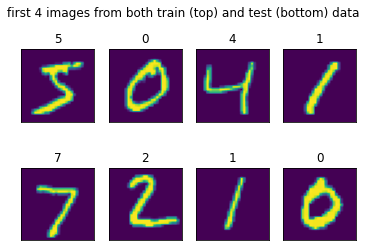

In [9]:
samples = 4
f, axes = plt.subplots(2, samples)
f.suptitle(f'first {samples} images from both train (top) and test (bottom) data')

for i in range(samples):
    # top row
    axes[0][i].imshow(X_train[i].reshape(28,28))
    axes[0][i].set_title("{:.0f}".format(y_train[i]))

    # bottom row
    axes[1][i].imshow(X_test[i].reshape(28,28))
    axes[1][i].set_title("{:.0f}".format(y_test[i]))

    # get rid of axes
    axes[0][i].set_xticks(())
    axes[0][i].set_yticks(())
    axes[1][i].set_xticks(())
    axes[1][i].set_yticks(())

### We investigate which pixel carry information and which ones don't.

By looking at the mean of the training set as image we can clearly see that the pixel towards the edge of the image are more likely to be the same for every digit. Meaning these features have not much variance. One can imagine a pixel which is always black doesn't help us much when trying to distinguish digits.

> The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.
>
>VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
>
> -- <cite>[sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)</cite>

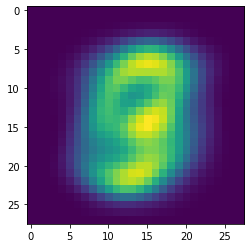

In [10]:
# visualize mean of the training set
plt.imshow(np.mean(X_train.reshape(-1,28,28), axis=0))

522 / 784 features selected


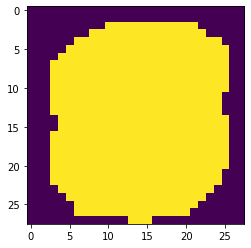

In [11]:
# lets find out more about the VarianceThreshold feature selection
# play with the threshold param and see how the image changes
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(100))
selector.fit(X_train)
zeros = np.zeros(28*28)
# select only the pixel from our dummy image
# that had a higher variance in the training set.
selected = selector.transform(zeros.reshape(1, -1))
# mark/color the selected features
selected += 255
print('%i / 784 features selected' % selected.shape[1])
# inverse the transformation to get a 28x28 image again
selected_features = selector.inverse_transform(selected)
plt.imshow(selected_features.reshape(28,28))

## Preprocessing
> The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.
>
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
>
> -- <cite>[sklearn](https://sklearn.org/modules/preprocessing.html#preprocessing)</cite>

So let's standardize features by removing the mean and scaling to unit variance

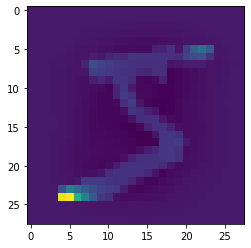

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardize features by removing the mean and scaling to unit variance
X_scaled = scaler.fit_transform(X_train, y_train)
# example of a scaled digit. inverse feature elimination first
# let's see what the scaling did to our data
plt.imshow(X_scaled[0].reshape(28,28))

## Classify Zero digits
For now we only want to tell '0' from other digits. We need a binary classifier for zero/non-zero.

We'll try a LogisticRegression with Gradient Descent first.

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# turn target values into booleans
y_binary = y_train == 0
y_test_binary = y_test == 0

# logistic regression with 5 epochs
sgdc = SGDClassifier(loss='log', max_iter=5)

# select features / reduce dimensionality and
# scale selected features before classifying
SGDC = make_pipeline(VarianceThreshold(),StandardScaler(),sgdc)
SGDC.fit(X_train, y_binary)

C:\Users\phil\anaconda3\envs\notebooks\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='log', max_iter=5))])

In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# use test data only!
y_pred = SGDC.predict(X_test)

f1 = f1_score(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)

# Let's see how we did.
print('accuracy: %f' %accuracy)
print('f1 score: %f' %f1)

accuracy: 0.989300
f1 score: 0.944703


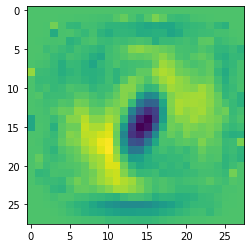

In [44]:
# lets look at the coefficients of the model
# one can definetly recognize a '0' in there
coef = SGDC['sgdclassifier'].coef_.copy()
plt.imshow(selector.inverse_transform(coef).reshape(28,28))

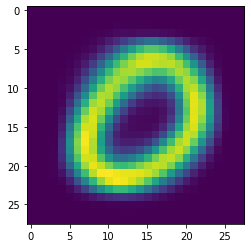

In [9]:
# mean of the digits we predicted to be zeroes
plt.imshow(np.mean(X_test[y_pred], axis=0).reshape(28,28))

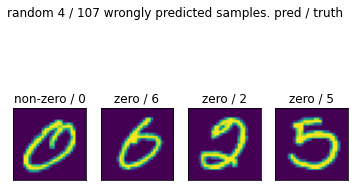

In [45]:
# inspect some we predicted wrong
X_pred_wrong = X_test[np.logical_not(y_pred == y_test_binary)]

# truth
actual_digit = y_test[np.logical_not(y_pred == y_test_binary)]

# holds if we wrongly predicted a zero or wrongly predicted a non-zero
# True -> false positive, we predicted a zero but it's not
# False -> false negative, we predicted a non-zero but it actually is
y_pred_wrong = y_pred[np.logical_not(y_pred == y_test_binary)]

samples = 4
f, axes = plt.subplots(1, samples)
f.suptitle(f'random {samples} / {len(y_pred_wrong)} wrongly predicted samples. pred / truth')

for i in range(samples):
    idx = np.random.randint(len(y_pred_wrong))
    we_predicted = "zero" if y_pred_wrong[idx] else "non-zero"
    axes[i].imshow(X_pred_wrong[idx].reshape(28,28))
    axes[i].set_title(we_predicted + " / " + "{:.0f}".format(actual_digit[idx]))

    # get rid of axes
    axes[i].set_xticks(())
    axes[i].set_yticks(())

Text(0.5, 1.0, 'digit is not zero')

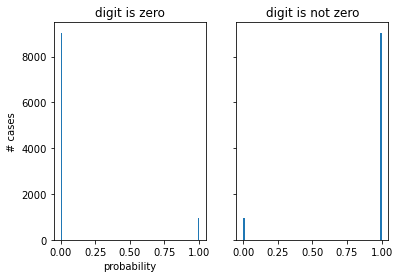

In [54]:
# clf.classes_
# let's see how sure our model is in its descision
digit_not_zero_proba = SGDC.predict_proba(X_test)[:,0]
digit_is_zero_proba = SGDC.predict_proba(X_test)[:,1]

# f, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot(121)
ax1.hist(digit_is_zero_proba, bins=100)
ax1.set_title("digit is zero")
ax1.set_ylabel("# cases")
ax1.set_xlabel("probability")
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.hist(digit_not_zero_proba, bins=100)
ax2.set_title("digit is not zero")

Looks like our model is always pretty sure about it's descision. Not too shabby considering the time spent fitting/learning. Let's move on.

## Classify all digits
Now we want to train a model that can tell if the drawn digit is a 0/1/2...8/9. We're gonna use a One-vs-rest model. Meaning a binary problem will be fit for each label individually.

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

LogRegOVR = Pipeline([
  ('feature_selection', VarianceThreshold()),
  ('feature_scaling', StandardScaler()),
#     use OVRC to parallelize the 10 binary fittings
  ('classification', OneVsRestClassifier(
      # run like
      estimator=LogisticRegression(multi_class='ovr',solver='saga', random_state=42, verbose=True),
      # use all cores available
      n_jobs=-1))
], verbose=True)

LogRegOVR.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', VarianceThreshold()),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr',
                                                                  random_state=42,
                                                                  solver='saga',
                                                                  verbose=1),
                                     n_jobs=-1))])

In [63]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# use test data only!
y_pred = LogRegOVR.predict(X_test)

# "weighted" accounts for class imbalance by computing the average of binary metrics
# in which each class’s score is weighted by its presence in the true data sample.
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Let's see how we did.
print('accuracy: %f' %accuracy)
print('f1 score: %f' %f1)

accuracy: 0.902900
f1 score: 0.902329


## Analysis
Let's get some metrics and then draw conclusions.

In [64]:
from sklearn.metrics import accuracy_score

# accuracy and f1 score for each binary classification
def accuracy_for_digit(d):
    y_digit_d = y_test == d
    # use boolean sample weight to only select the digits in question
    return accuracy_score(y_test, y_pred, sample_weight=y_digit_d)

digits = range(10)
accs = []
for digit in digits:
    accs += [accuracy_for_digit(digit)]

accs = np.array(accs)
f1s = f1_score(y_test,y_pred, average=None)

# mean of probabilities for each label (pos/neg) of each binary classification
def mean_proba_digit(d):
    # shape i.e (1013,10) .. (samples,classes)
    proba_per_class = LogRegOVR.predict_proba(X_test[y_test==d])
    pos = np.mean(proba_per_class[:,d])
    # probabilities for each class except digit d .. in other words neg proba
    proba_per_class_except_d = np.append(proba_per_class[:,:d],proba_per_class[:,d+1:],axis=1)
    # first sum for each sample the probas for not being digit d, then mean those means over all samples
    # probably 1-pos woulda been better? idk.
    # lol turns out it is exactly the same ... all the complex indexing for nothing :) 
    neg = np.mean(np.sum(proba_per_class_except_d,axis=1))
    return neg, pos

# fill np arrays
mean_proba_digits_neg = []
mean_proba_digits_pos = []
for i in digits:
    neg, pos = mean_proba_digit(i)
    mean_proba_digits_neg += [neg]
    mean_proba_digits_pos += [pos]
    
mean_neg = np.array(mean_proba_digits_neg)
mean_pos = np.array(mean_proba_digits_pos)

In [65]:
# show metrics in table
import pandas as pd
df = pd.DataFrame()

df['accuracy'] = accs
df['f1 score'] = f1s
df['mean neg proba'] = mean_neg
df['mean pos proba'] = mean_pos

df

,accuracy,f1 score,mean neg proba,mean pos proba
0,0.979592,0.954749,0.204696,0.795304
1,0.971806,0.940725,0.252513,0.747487
2,0.868217,0.897796,0.324305,0.675695
3,0.896040,0.901394,0.324101,0.675899
4,0.926680,0.903674,0.318508,0.681492
5,0.838565,0.860759,0.386155,0.613845
6,0.941545,0.930857,0.243548,0.756452
7,0.901751,0.897386,0.300156,0.699844
8,0.838809,0.853264,0.380075,0.619925
9,0.853320,0.874556,0.376253,0.623747


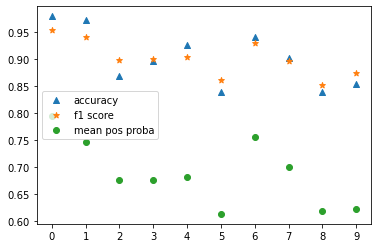

In [66]:
plt.scatter(digits,accs,label='accuracy',marker='^')
plt.scatter(digits,f1s,label='f1 score',marker='*')
plt.scatter(digits,mean_pos,label='mean pos proba',marker='o')
plt.xticks(digits)
plt.legend(loc='best')

Text(0.5, 1.0, 'wrongly predicted digits with OVR LogisticRegression')

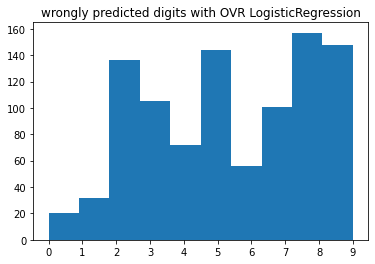

In [67]:
wrongly_pred = y_test[np.logical_not(y_pred == y_test)]
plt.hist(wrongly_pred)
plt.xticks(digits)
plt.title('wrongly predicted digits with OVR LogisticRegression')

We can see that our model has a hard time predicting the digits `8` and `9`. But it's really good at predicting digits `0` and `1`.

Text(0.5, 0.98, 'Classification vectors for all digits')

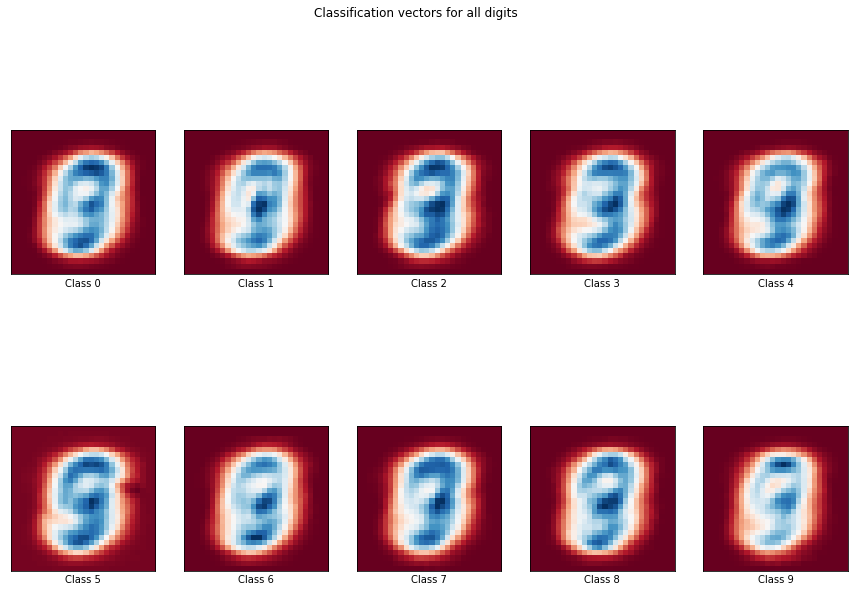

In [71]:
# OneVsRestClassifier created 10 binary LogisticRegression estimators for us
# i.e clf['classification'].estimators_

plt.figure(figsize=(15, 10))
for i in range(10):
    # get references and reverse transform coef through the pipeline
    coef = LogRegOVR['classification'].estimators_[i].coef_.copy()
    coef = LogRegOVR['feature_scaling'].inverse_transform(coef)
    coef = LogRegOVR['feature_selection'].inverse_transform(coef)
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef.reshape(28, 28), cmap=plt.cm.RdBu)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vectors for all digits')

## Detect my own handwriting

For this i drew some digits on my tablet. I created a new 24 bit greyscale canvas in GIMP and scaled down my digits onto it.

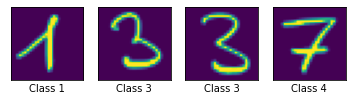

In [85]:
from PIL import Image

imgs = ["one.bmp","three1.bmp","three2.bmp","seven.bmp"]

# digit 7 fails! .. predicts as 4 because i have a different writing style for this digit

for i in range(len(imgs)):
    l1_plot = plt.subplot(1, len(imgs), i + 1)
    img = Image.open(imgs[i])
    p = np.array(img, dtype=np.float64).reshape(1,-1)
    pred = LogRegOVR.predict(p)[0]
    l1_plot.imshow(p.reshape(28, 28))
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % pred)

## Compare performance to SVM
We will test some Support Vector Machines next.

In [86]:
#TODO CONTINUE refactoring

In [26]:
from sklearn.svm import LinearSVC

clf = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=LinearSVC(dual=False,verbose=True),
    # use all cores available
      n_jobs=-1)),
], verbose=True)

clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=100)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LinearSVC(dual=False),
                                     n_jobs=-1))])

In [41]:
clf.score(X_test,y_test)

array([2.])

In [42]:
from sklearn.svm import SVC

deg3polySVC = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          # https://en.wikipedia.org/wiki/MNIST_database has an entry for a poly deg9 kernel SVM with a good score
          kernel='poly',
          degree=3,
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
deg3polySVC.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.7s
[Pipeline] .... (step 2 of 2) Processing classification, total=28.7min


Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000,
                                                   kernel='poly',
                                                   verbose=True),
                                     n_jobs=-1))],
         verbose=True)

In [43]:
deg3polySVC.score(X_test,y_test) 
# 0.9753 with deg=3, 0.9703 with deg 4 (takes time!)
# 0.9678 without VarianceThreshold deg 3

0.9678

In [33]:
rbfSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='rbf',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
rbfSVC.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=21.1min


Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000),
                                     n_jobs=-1))],
         verbose=True)

In [34]:
rbfSVC.score(X_test,y_test)

0.9681

In [35]:
sigmoidSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='sigmoid',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
sigmoidSVC.fit(X_train, y_train)
sigmoidSVC.score(X_test,y_test)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=19.1min


0.817

In [ ]:
# conda activate notebooks

In [ ]:
# pip install scipy scikit-learn